In [1]:
using DataFrames,PythonPlot,StatsBase,Random,Distributions,CSV
PythonPlot.svg(true)
include("./process_mm_data.jl")

FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/Finite Lineages Plos Journal/paper/figures"

"/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/Finite Lineages Plos Journal/paper/figures"

In [2]:
# make dataframe from CSV file
DATA_PATH = "./data/MC4100_25C"
data = [CSV.read(DATA_PATH*"/"*f,DataFrame,header=string.(["row","div","length","x","z"])) for f in readdir(DATA_PATH)]
data = vcat([hcat(data[i],DataFrame(:lineage=>i*ones(length(data[i][:,1])))) for i in eachindex(data)]...)
data = combine(groupby(data,:lineage),:div => cumsum => :n,names(data));


# Apply the function to each lineage and concatenate results
data = vcat([process_lineage(c) for c in groupby(data, :lineage)]...);
data.z = data.Y .- data.T .* log(2);


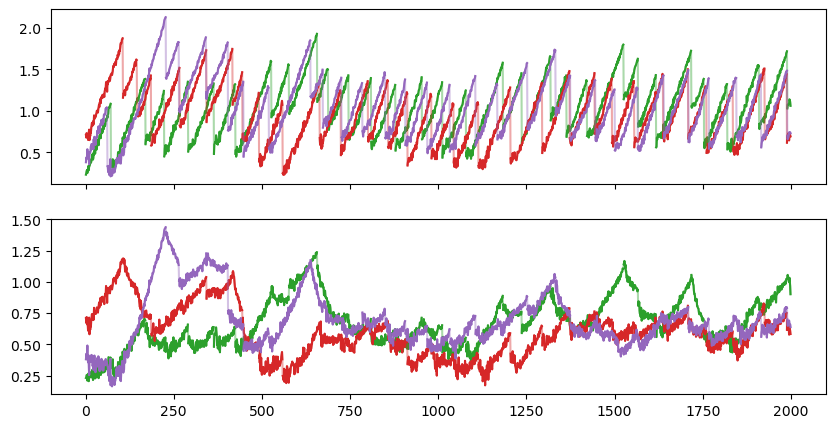

In [3]:

fig,axs = subplots(figsize=(10,5),nrows=2,sharex=true)

for k in 3:5
    df = data[data.lineage .==k,:]
    df = df[df.time .< 2000,:]
    ax = axs[0]
    ax.plot(df.time,df.Y,"C$(k-1)-",alpha=0.4)
    [ax.plot(d.time,d.Y,"C$(k-1)-") for d in groupby(df,[:cell])]

    ax = axs[1]
    ax.plot(df.time,df.z,"C$(k-1)-",alpha=0.4)
    [ax.plot(d.time,d.z,"C$(k-1)-") for d in groupby(df,[:cell])]
end
fig

In [8]:
data

Row,lineage,n,row,div,length,x,z,Y,time,cell,z0,S,τ,age,T
,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64?,Int64?,Int64?,Float64?,Float64?,Float64?,Int64?,Float64?
1,1.0,1,1,1,1.5261,216721.0,0.422715,0.422715,1,1,0.422715,0.845431,71.0,0,0.0
2,1.0,1,2,0,1.68142,227982.0,0.509876,0.519639,2,1,0.422715,1.36507,71.0,1,0.0140845
3,1.0,1,3,0,1.53322,211008.0,0.407845,0.42737,3,1,0.422715,1.69552,71.0,2,0.028169
4,1.0,1,4,0,1.49913,206440.0,0.375597,0.404885,4,1,0.422715,2.09575,71.0,3,0.0422535
5,1.0,1,5,0,1.52529,213933.0,0.383134,0.422185,5,1,0.422715,2.53576,71.0,4,0.056338
6,1.0,1,6,0,1.52529,213325.0,0.373371,0.422185,6,1,0.422715,2.95848,71.0,5,0.0704225
7,1.0,1,7,0,1.53322,215622.0,0.368794,0.42737,7,1,0.422715,3.38638,71.0,6,0.084507
8,1.0,1,8,0,1.50543,204034.0,0.34074,0.409079,8,1,0.422715,3.7908,71.0,7,0.0985915
9,1.0,1,9,0,1.51407,204854.0,0.3367,0.414801,9,1,0.422715,4.21924,71.0,8,0.112676


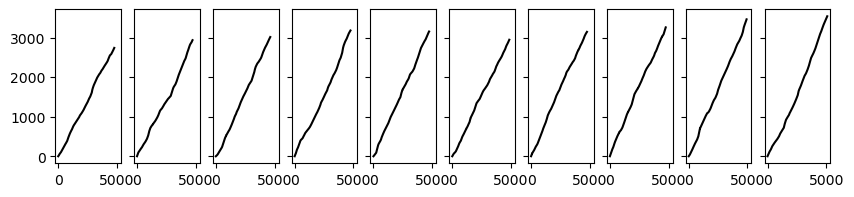

In [4]:

fig,axs = subplots(figsize=(10,2),ncols=10,sharex=true,sharey=true)

for k in 1:10
    ax = axs[k-1]
    df = data[data.lineage .==k,:]
    ax.plot(df.time,df.S,"k-")
end
fig

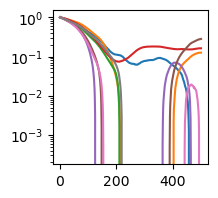

In [7]:
fig,ax = subplots(figsize=(2,2))
lags = collect(1:500)
for i in unique(data.lineage)[1:8]
    df = data[data.lineage .== i,:]
    acf = [cov(df.z[k:end],df.z[1:end-k+1]) for k in lags]
    ax.semilogy(lags,acf ./acf[1])
end
fig

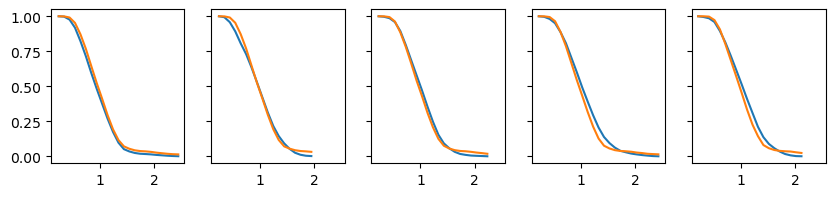

In [20]:

fig,axs = subplots(figsize=(10,2),ncols=5,sharex=true,sharey=true)

for k in 1:5
    ax = axs[k-1]
    df = data[data.lineage .==k,:]
    yrang = minimum(df.Y):0.1:maximum(df.Y)
    ax.plot(yrang,1 .-[sum(df.Y .< y)/length(df.Y) for y in yrang])

    df = data[data.lineage .== 1,:];
    s_range = collect(minimum(df.S):1:maximum(df.S))

    Y_tc = [mean(df[(df.S .> s_range[i]) .& (df.S .< s_range[i+1]),:Y]) for i in 1:(length(s_range)-1)]
    ax.plot(yrang,1 .-[sum(Y_tc .< y)/length(Y_tc) for y in yrang])
end
fig

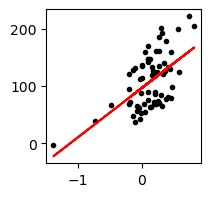

In [25]:

dfcell = combine(groupby(data,:cell),:z => (x -> x[1])=>:z0, 
    :z => (x -> x[end] - x[1])=>:ϕ,
    :time => (x -> x[end]-x[1])=>:τ)

    fig,ax = subplots(figsize=(2,2))
dfcell.λ = dfcell.ϕ ./ dfcell.τ
ax.plot(dfcell.ϕ,dfcell.τ,"k.")
slope = cov(dfcell.ϕ,dfcell.τ)/var(dfcell.ϕ)
inter = mean(dfcell.τ) - slope*mean(dfcell.ϕ)
ax.plot(dfcell.ϕ, slope.*dfcell.ϕ .+ inter,"r-")
fig

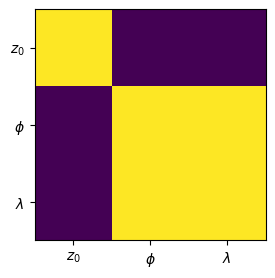

In [36]:
Y = Matrix(dfcell[:,[:z0,:ϕ,:λ]])
Y = Y .- mean(Y,dims=2) # center the data
Y = Y ./ std(Y,dims=2) # scale the data
fig,ax = subplots(figsize=(3,3))
ax.imshow(Int64.(Y'Y .> 0) )
ax.set_xticks([0,1,2])
ax.set_xticklabels([L"z_0",L"\phi",L"\lambda"])
ax.set_yticks([0,1,2])
ax.set_yticklabels([L"z_0",L"\phi",L"\lambda"])
fig

In [ ]:
cov(diff(df.dY),df.dY[1:end-1]) / var(df.dY)



function autocorr(x::Vector{T},y::Vector{T}) where T
    return cov(diff(x),y[1:end-1]) / var(x)
end

x,y = diff(df.dY),df.dY[1:end-1]
autocorr(x,y)

-0.014455279351676488

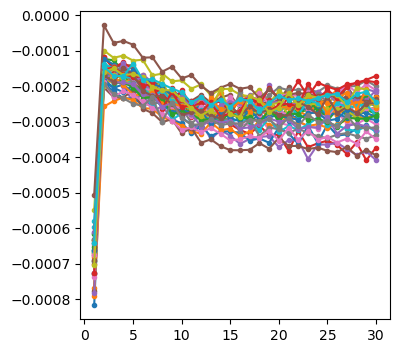

In [64]:
# compute the time lagged autocorrelation function between dY and dY'
function autocorr(x::Vector{T},y::Vector{T},lag::Int) where T
    return cov(y[1:end-lag],x[1+lag:end])
end

lags = 1:30
fig, ax= subplots(figsize=(4,4))
for lin in 1:40
    df = data[data.lineage .==lin,:]
    x,y = diff(df.dY),df.dY[1:end-1]
    acf = [autocorr(x,y,lag-1) for lag in lags]
    ax.plot(lags,acf,".-")
end
fig